In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

In [2]:
import pandas as pd
idx = pd.IndexSlice

import datetime as dt
from datetime import date
from datetime import timedelta
import dateutil.parser as dup

%aimport trans.data
%aimport trans.gtrans
%aimport trans.reg
%aimport trans.regpipe

from trans.data import GetData
gd = GetData()
from trans.gtrans import *
from trans.reg import Reg, RegAttr
from trans.regpipe import RegPipe

## Memorialize: a switch that causes repeatability by fixing the end date, etc.  
## It then writes is output to a "verify_" file for regression testing


In [3]:
Memorialize = False

In [4]:
today = dt.datetime.combine( date.today(), dt.time.min)
if Memorialize:
    today = dup.parse("03/09/2018")
    
end_fixed = today
today

start = dup.parse("01/01/2000")
start

datetime.datetime(2018, 4, 9, 0, 0)

datetime.datetime(2000, 1, 1, 0, 0)

In [5]:
gd = GetData()
univ = gd.existing()
univ.sort()

len(univ)

1118

In [6]:
sectors =  { 
    "Consumer Discretionary": "XLY",
    "Consumer Staples": "XLP",
    "Energy": "XLE",
    "Financial": "XLF",
    "Health": "XLV",
    "Industrial": "XLI", 
    "Materials" : "XLB",
    "Real Estate": "XLRE",
    "Technology": "XLK", 
    "Telecom": "XTL",
    "Utilities": "XLU"
}
   

In [7]:
sector_tickers = list( sectors.values() )

In [8]:
sector_tickers

['XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLRE', 'XLK', 'XTL', 'XLU']

## Download data

In [9]:
get = False
if get:
    changed_tickers = gd.get_data( sector_tickers, start, today )
    len(changed_tickers)
    list( set(sector_tickers) - set(changed_tickers))

## Assemble data (already downloaded) into DataFrame
- Note: The index will be a DateTime already, no need to convert from string. No need for DatetimeIndexTransformer
- Note: the index will be restricted to dates from SPY, no need for RestrictToCalendarColTransformer

In [10]:
price_df = GetDataTransformer(sector_tickers, cal_ticker="SPY").fit_transform( pd.DataFrame())
if Memorialize:
    price_df = price_df.loc[:end_fixed,:]
    
price_df.shape

(4594, 72)

In [11]:
price_df.index.min()
price_df.index.max()
price_df.loc[:, idx["Adj Close",:]].shape

if Memorialize:
    gd.save_data( price_df.loc[:, idx["Adj Close",:]], "verify_sectors_raw_df.pkl")

Timestamp('2000-01-03 00:00:00')

Timestamp('2018-04-06 00:00:00')

(4594, 12)

## Compute returns

In [12]:
type(price_df.index)

pandas.tseries.index.DatetimeIndex

In [13]:
pipe_pct   = make_pipeline(GenSelectAttrsTransformer(['Adj Close'], dropSingle=False),
                           pctTrans,
                           GenRenameAttrsTransformer(lambda col: "Pct", level=0)
                          )
pct_df = pipe_pct.fit_transform(price_df)
pct_df.tail()

transform: pandas version <= 0.20.


Pct                                                    \
                 SPY       XLB       XLE       XLF       XLI       XLK   
Dt                                                                       
2018-04-02 -0.021585 -0.021777 -0.020027 -0.022126 -0.020595 -0.023846   
2018-04-03  0.001631 -0.002693 -0.004995  0.002226 -0.000275 -0.005637   
2018-04-04  0.021986  0.023582  0.025103  0.022206  0.018559  0.029764   
2018-04-05  0.007892  0.018642  0.017958  0.007965  0.010123  0.004129   
2018-04-06 -0.022361 -0.024344 -0.018078 -0.024066 -0.027659 -0.024520   

                                                                        
                 XLP      XLRE       XLU       XLV       XLY       XTL  
Dt                                                                      
2018-04-02 -0.024511 -0.012226 -0.007718 -0.022727 -0.028236 -0.019454  
2018-04-03  0.002532 -0.000489  0.000299 -0.000126  0.000203  0.007551  
2018-04-04  0.026423  0.015806  0.005284  0.029796  0.031082  0.015724  
2018-04-05  0.002461  0.000962  0.007933 -0.000733  0.013398  0.007378  
2018-04-06 -0.010196 -0.010256 -0.007871 -0.024068 -0.021289 -0.013177

In [14]:
if Memorialize:
    gd.save_data( pct_df, "verify_sectors_pct_df.pkl")

## Alternate way of creating Returns: drop attribute and re-add

In [15]:
pipe_pct   = make_pipeline(GenSelectAttrsTransformer(['Adj Close'], dropSingle=True), 
                           # RestrictToCalendarColTransformer( "SPY" ),
                           pctTrans,
                           # DatetimeIndexTransformer("Dt"),
                           # RestrictToNonNullTransformer("all"),
                           AddAttrTransformer('Pct')
                      )
pct_df = pipe_pct.fit_transform(price_df)
pct_df.shape
pct_df.tail()

(4594, 12)

Pct                                                    \
                 SPY       XLB       XLE       XLF       XLI       XLK   
Dt                                                                       
2018-04-02 -0.021585 -0.021777 -0.020027 -0.022126 -0.020595 -0.023846   
2018-04-03  0.001631 -0.002693 -0.004995  0.002226 -0.000275 -0.005637   
2018-04-04  0.021986  0.023582  0.025103  0.022206  0.018559  0.029764   
2018-04-05  0.007892  0.018642  0.017958  0.007965  0.010123  0.004129   
2018-04-06 -0.022361 -0.024344 -0.018078 -0.024066 -0.027659 -0.024520   

                                                                        
                 XLP      XLRE       XLU       XLV       XLY       XTL  
Dt                                                                      
2018-04-02 -0.024511 -0.012226 -0.007718 -0.022727 -0.028236 -0.019454  
2018-04-03  0.002532 -0.000489  0.000299 -0.000126  0.000203  0.007551  
2018-04-04  0.026423  0.015806  0.005284  0.029796  0.031082  0.015724  
2018-04-05  0.002461  0.000962  0.007933 -0.000733  0.013398  0.007378  
2018-04-06 -0.010196 -0.010256 -0.007871 -0.024068 -0.021289 -0.013177

In [16]:
from dateutil.relativedelta import relativedelta, FR
lastFriday = today + relativedelta(weekday=FR(-1))

In [17]:
import dateutil.parser as dup
import dateutil.relativedelta as rd

regWindow = rd.relativedelta(months=+6)
regStep   = rd.relativedelta(weeks=+4)

regStart = dup.parse("01/01/2000")
regEnd = lastFriday
if Memorialize:
    regEnd   = dup.parse("12/29/2017")
# regEnd   = dup.parse("02/28/2018")

In [18]:
regParams = { "start": regStart, "end": regEnd, "window": regWindow, "step": regStep }
if Memorialize:
    gd.save_data( regParams, "verify_regParams.pkl")

## Compute the model: 
$Return_{sector ticker} = \beta_0 + \beta * Return_{SPY} + \epsilon$

In [19]:
rp = RegPipe( pct_df )
rp.indCols( [ idx["Pct", "SPY"] ] )
rp.regress( regStart, regEnd, regWindow, regStep)

IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLB'), cols [('Pct', 'SPY'), ('Pct', 'XLB')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLE'), cols [('Pct', 'SPY'), ('Pct', 'XLE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLF'), cols [('Pct', 'SPY'), ('Pct', 'XLF')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLI'), cols [('Pct', 'SPY'), ('Pct', 'XLI')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLK'), cols [('Pct', 'SPY'), ('Pct', 'XLK')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLP'), cols [('Pct', 'SPY'), ('Pct', 'XLP')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLRE'), cols [('Pct', 'SPY'), ('Pct', 'XLRE')]
Fit: the following columns have naN:  ['XLRE']
Fit: the following columns have naN:  ['XLRE']
Fit: the following columns have naN:  ['XLRE']
Fit: the following columns have naN:  ['XLRE']
Fit: the following columns have naN:  ['XLRE']
Fit: the following columns have naN:  ['XLRE']
Fit: the following columns have naN:  ['XLRE']
Fit: the following columns have naN:  ['XLRE']
Fit: t

In [20]:
rp.beta_df.shape
rp.beta_df.tail()

(232, 22)

Beta 0                                                    \
                     XLB       XLE       XLF       XLI       XLK       XLP   
Dt                                                                           
2017-12-15 -1.422704e-05  0.000100  0.000306 -0.000108  0.000120 -0.000294   
2018-01-12 -1.435423e-07  0.000736  0.000138  0.000078 -0.000071 -0.000020   
2018-02-09  1.478549e-04 -0.000106  0.000222  0.000123  0.000176 -0.000440   
2018-03-09 -1.044846e-04 -0.000357  0.000602  0.000115  0.000374 -0.000667   
2018-04-06 -3.585119e-04 -0.000207  0.000074 -0.000073  0.000336 -0.000281   

                                                      ...       Beta 1  \
                XLRE       XLU       XLV       XLY    ...          XLE   
Dt                                                    ...                
2017-12-15 -0.000104  0.000171 -0.000066 -0.000080    ...     0.595558   
2018-01-12 -0.000391 -0.000167 -0.000268  0.000183    ...     0.762249   
2018-02-09 -0.000733 -0.000795 -0.000154  0.000414    ...     0.920964   
2018-03-09 -0.001026 -0.001155 -0.000567  0.000513    ...     0.965968   
2018-04-06 -0.000394 -0.000438 -0.000457  0.000586    ...     0.982967   

                                                                        \
                 XLF       XLI       XLK       XLP      XLRE       XLU   
Dt                                                                       
2017-12-15  1.020384  1.052920  1.418574  0.561804  0.530267  0.174152   
2018-01-12  1.101864  1.058393  1.354621  0.429370  0.357483  0.067103   
2018-02-09  1.115798  1.015323  1.220437  0.619450  0.566114  0.244795   
2018-03-09  1.095696  1.021995  1.185922  0.669893  0.594819  0.378279   
2018-04-06  1.099590  1.051941  1.184890  0.658753  0.532844  0.324006   

                                          
                 XLV       XLY       XTL  
Dt                                        
2017-12-15  0.898750  0.968484  1.163196  
2018-01-12  0.933367  0.999419  1.181681  
2018-02-09  0.941997  0.912110  0.837640  
2018-03-09  0.950807  0.894230  0.845706  
2018-04-06  0.967147  0.961264  0.840217  

[5 rows x 22 columns]

## Compute residuals:
 - For residual, don't roll beta: the date of the beta is the last date of the regression window
 - Fill the beta backwards, so the in-sample beta is applied

In [21]:
rollAmount = 0
fillMethod = "bfill"

rp.attrib_setup(pct_df, rp.beta_df, rollAmount, fillMethod)

In [22]:
rp.attrib()

rp.retAttr_df.shape
rp.retAttr_df.loc[:"2017-12-29",:].tail()

(4602, 44)

Contrib from 1                                                   \
                      XLB       XLE       XLF       XLI       XLK      XLP   
Dt                                                                           
2017-12-22  -1.435423e-07  0.000736  0.000138  0.000078 -0.000071 -0.00002   
2017-12-26  -1.435423e-07  0.000736  0.000138  0.000078 -0.000071 -0.00002   
2017-12-27  -1.435423e-07  0.000736  0.000138  0.000078 -0.000071 -0.00002   
2017-12-28  -1.435423e-07  0.000736  0.000138  0.000078 -0.000071 -0.00002   
2017-12-29  -1.435423e-07  0.000736  0.000138  0.000078 -0.000071 -0.00002   

                                                      ...        Error  \
                XLRE       XLU       XLV       XLY    ...          XLE   
Dt                                                    ...                
2017-12-22 -0.000391 -0.000167 -0.000268  0.000183    ...     0.001552   
2017-12-26 -0.000391 -0.000167 -0.000268  0.000183    ...     0.008929   
2017-12-27 -0.000391 -0.000167 -0.000268  0.000183    ...    -0.004413   
2017-12-28 -0.000391 -0.000167 -0.000268  0.000183    ...    -0.000784   
2017-12-29 -0.000391 -0.000167 -0.000268  0.000183    ...    -0.000760   

                                                                        \
                 XLF       XLI       XLK       XLP      XLRE       XLU   
Dt                                                                       
2017-12-22 -0.002693  0.000464 -0.000194  0.001718  0.007005  0.001712   
2017-12-26 -0.001672  0.002249 -0.004971  0.002820  0.006063 -0.005663   
2017-12-27  0.000399  0.001792  0.000503 -0.000364  0.004206  0.004354   
2017-12-28  0.001524 -0.000273 -0.001002 -0.002442  0.005463  0.005568   
2017-12-29 -0.003098  0.002066 -0.000110  0.001463  0.002651  0.000990   

                                          
                 XLV       XLY       XTL  
Dt                                        
2017-12-22 -0.002734 -0.001837 -0.004848  
2017-12-26  0.001626  0.003236 -0.001902  
2017-12-27  0.001502 -0.002685  0.002194  
2017-12-28 -0.000208  0.000488 -0.000101  
2017-12-29 -0.002343 -0.002257 -0.004086  

[5 rows x 44 columns]

## Demonstrate a non-rolling

In [23]:
regStarts = regEnd - regWindow + timedelta(days=1)

pct_dfs = pct_df.loc[ regStarts:regEnd,:]

rps = RegPipe( pct_dfs )
rps.indCols( [ idx["Pct", "SPY"] ] )
rps.regressSingle()

rps.beta_df.shape
rps.beta_df.tail()

IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLB'), cols [('Pct', 'SPY'), ('Pct', 'XLB')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLE'), cols [('Pct', 'SPY'), ('Pct', 'XLE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLF'), cols [('Pct', 'SPY'), ('Pct', 'XLF')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLI'), cols [('Pct', 'SPY'), ('Pct', 'XLI')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLK'), cols [('Pct', 'SPY'), ('Pct', 'XLK')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLP'), cols [('Pct', 'SPY'), ('Pct', 'XLP')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLRE'), cols [('Pct', 'SPY'), ('Pct', 'XLRE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLU'), cols [('Pct', 'SPY'), ('Pct', 'XLU')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLV'), cols [('Pct', 'SPY'), ('Pct', 'XLV')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLY'), cols [('Pct', 'SPY'), ('Pct', 'XLY')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XTL'), cols [('Pct', 'SPY'), ('Pct', 'XTL')]


(1, 22)

Beta 0                                                    \
                 XLB       XLE       XLF       XLI       XLK       XLP   
Dt                                                                       
2018-04-06 -0.000359 -0.000207  0.000074 -0.000073  0.000336 -0.000281   

                                                      ...       Beta 1  \
                XLRE       XLU       XLV       XLY    ...          XLE   
Dt                                                    ...                
2018-04-06 -0.000394 -0.000438 -0.000457  0.000586    ...     0.982967   

                                                                      \
                XLF       XLI      XLK       XLP      XLRE       XLU   
Dt                                                                     
2018-04-06  1.09959  1.051941  1.18489  0.658753  0.532844  0.324006   

                                          
                 XLV       XLY       XTL  
Dt                                        
2018-04-06  0.967147  0.961264  0.840217  

[1 rows x 22 columns]

In [24]:
if Memorialize:
    gd.save_data( rps.beta_df, "verify_beta_df.pkl")

In [25]:
rollAmount = 0
fillMethod = "bfill"

rps.attrib_setup(pct_dfs, rps.beta_df, rollAmount, fillMethod)
rps.attrib()

rps.retAttr_df.shape
rps.retAttr_df.loc[:"2017-12-29",:].tail()

(124, 44)

Contrib from 1                                                    \
                      XLB       XLE       XLF       XLI       XLK       XLP   
Dt                                                                            
2017-12-22      -0.000359 -0.000207  0.000074 -0.000073  0.000336 -0.000281   
2017-12-26      -0.000359 -0.000207  0.000074 -0.000073  0.000336 -0.000281   
2017-12-27      -0.000359 -0.000207  0.000074 -0.000073  0.000336 -0.000281   
2017-12-28      -0.000359 -0.000207  0.000074 -0.000073  0.000336 -0.000281   
2017-12-29      -0.000359 -0.000207  0.000074 -0.000073  0.000336 -0.000281   

                                                      ...        Error  \
                XLRE       XLU       XLV       XLY    ...          XLE   
Dt                                                    ...                
2017-12-22 -0.000394 -0.000438 -0.000457  0.000586    ...     0.002553   
2017-12-26 -0.000394 -0.000438 -0.000457  0.000586    ...     0.010137   
2017-12-27 -0.000394 -0.000438 -0.000457  0.000586    ...    -0.003577   
2017-12-28 -0.000394 -0.000438 -0.000457  0.000586    ...    -0.000295   
2017-12-29 -0.000394 -0.000438 -0.000457  0.000586    ...     0.001016   

                                                                        \
                 XLF       XLI       XLK       XLP      XLRE       XLU   
Dt                                                                       
2017-12-22 -0.002630  0.000613 -0.000646  0.002039  0.007053  0.002051   
2017-12-26 -0.001610  0.002392 -0.005581  0.003355  0.006275 -0.005085   
2017-12-27  0.000464  0.001946  0.000179 -0.000215  0.004124  0.004500   
2017-12-28  0.001592 -0.000109 -0.001060 -0.002653  0.005104  0.005310   
2017-12-29 -0.003043  0.002192 -0.001157  0.002589  0.003314  0.002230   

                                          
                 XLV       XLY       XTL  
Dt                                        
2017-12-22 -0.002536 -0.002251 -0.005746  
2017-12-26  0.001855  0.002786 -0.003120  
2017-12-27  0.001675 -0.003070  0.001551  
2017-12-28 -0.000088  0.000163 -0.000207  
2017-12-29 -0.002027 -0.002804 -0.006183  

[5 rows x 44 columns]

In [26]:
sector_residuals = rps.retAttr_df.loc[:, idx["Error",:]]
sector_residuals.tail()

Error                                                    \
                 XLB       XLE       XLF       XLI       XLK       XLP   
Dt                                                                       
2018-04-02  0.000961  0.001397  0.001535  0.002184  0.001393 -0.010010   
2018-04-03 -0.004026 -0.006392  0.000358 -0.001918 -0.007906  0.001739   
2018-04-04  0.001145  0.003698 -0.002044 -0.004496  0.003377  0.012221   
2018-04-05  0.010818  0.010408 -0.000787  0.001894 -0.005558 -0.002457   
2018-04-06 -0.000801  0.004109  0.000448 -0.004064  0.001639  0.004815   

                                                              
                XLRE       XLU       XLV       XLY       XTL  
Dt                                                            
2018-04-02 -0.000331 -0.000286 -0.001395 -0.008073 -0.000958  
2018-04-03 -0.000964  0.000209 -0.001246 -0.001951  0.006541  
2018-04-04  0.004484 -0.001402  0.008990  0.009361 -0.002389  
2018-04-05 -0.002849  0.005815 -0.007908  0.005225  0.001108  
2018-04-06  0.002052 -0.000188 -0.001985 -0.000380  0.005972

In [27]:
if Memorialize:
    gd.save_data(sector_residuals, "sector_residuals.pkl")

In [28]:
resStart = dup.parse("01/01/2016")

## OBSOLETE, replaced by trans.stack_residual

In [29]:
from trans.stack import Stack
%aimport trans.stack

s = Stack(pct_df)
stack = s.repeated(resStart, regEnd, regWindow, regStep)

IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLB'), cols [('Pct', 'SPY'), ('Pct', 'XLB')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLE'), cols [('Pct', 'SPY'), ('Pct', 'XLE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLF'), cols [('Pct', 'SPY'), ('Pct', 'XLF')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLI'), cols [('Pct', 'SPY'), ('Pct', 'XLI')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLK'), cols [('Pct', 'SPY'), ('Pct', 'XLK')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLP'), cols [('Pct', 'SPY'), ('Pct', 'XLP')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLRE'), cols [('Pct', 'SPY'), ('Pct', 'XLRE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLU'), cols [('Pct', 'SPY'), ('Pct', 'XLU')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLV'), cols [('Pct', 'SPY'), ('Pct', 'XLV')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLY'), cols [('Pct', 'SPY'), ('Pct', 'XLY')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XTL'), cols [('Pct', 'SPY'), ('Pct', 'XTL')]
IndCols: [('Pct', 'SPY')], dep

In [30]:
for stk in stack :
    suffix = stk[0].strftime("%Y%m%d")
    data = stk[1]
    
    if Memorialize:
        gd.save_data(data, "sector_residuals_{}.pkl".format(suffix))
    
             

## Residual stack

In [31]:
%aimport trans.stacked.residual
from trans.stacked.residual import Residual

rstack = Residual(debug=True)
rstack.init(df=pct_df, start=resStart, end=regEnd, window=regWindow, step=regStep)
resid_stack = rstack.repeated()
rstack.done()

nextChunk for period 2017-10-07 00:00:00 to 2018-04-06 00:00:00 shape: (124, 12)
repeated: chunk label 2018-04-06 00:00:00 with shape (124, 12)
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLB'), cols [('Pct', 'SPY'), ('Pct', 'XLB')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLE'), cols [('Pct', 'SPY'), ('Pct', 'XLE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLF'), cols [('Pct', 'SPY'), ('Pct', 'XLF')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLI'), cols [('Pct', 'SPY'), ('Pct', 'XLI')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLK'), cols [('Pct', 'SPY'), ('Pct', 'XLK')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLP'), cols [('Pct', 'SPY'), ('Pct', 'XLP')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLRE'), cols [('Pct', 'SPY'), ('Pct', 'XLRE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLU'), cols [('Pct', 'SPY'), ('Pct', 'XLU')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLV'), cols [('Pct', 'SPY'), ('Pct', 'XLV')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLY'), cols [('Pct'

In [32]:
if Memorialize:
    gd.save_data( resid_stack, "verify_resid_stack.pkl")

In [33]:
for stk in resid_stack :
    suffix = stk[0].strftime("%Y%m%d")
    data = stk[1]
    
    print("Stack {} shape: {}".format(stk[0], stk[1].shape))
    #gd.save_data(data, "sector_residuals_{}.pkl".format(suffix))         

Stack 2018-04-06 00:00:00 shape: (124, 11)
Stack 2018-03-09 00:00:00 shape: (125, 11)
Stack 2018-02-09 00:00:00 shape: (127, 11)
Stack 2018-01-12 00:00:00 shape: (128, 11)
Stack 2017-12-15 00:00:00 shape: (128, 11)
Stack 2017-11-17 00:00:00 shape: (129, 11)
Stack 2017-10-20 00:00:00 shape: (128, 11)
Stack 2017-09-22 00:00:00 shape: (128, 11)
Stack 2017-08-25 00:00:00 shape: (127, 11)
Stack 2017-07-28 00:00:00 shape: (126, 11)
Stack 2017-06-30 00:00:00 shape: (125, 11)
Stack 2017-06-02 00:00:00 shape: (124, 11)
Stack 2017-05-05 00:00:00 shape: (124, 11)
Stack 2017-04-07 00:00:00 shape: (125, 11)
Stack 2017-03-10 00:00:00 shape: (125, 11)
Stack 2017-02-10 00:00:00 shape: (127, 11)
Stack 2017-01-13 00:00:00 shape: (128, 11)
Stack 2016-12-16 00:00:00 shape: (128, 11)
Stack 2016-11-18 00:00:00 shape: (129, 11)
Stack 2016-10-21 00:00:00 shape: (128, 11)
Stack 2016-09-23 00:00:00 shape: (128, 11)
Stack 2016-08-26 00:00:00 shape: (127, 11)
Stack 2016-07-29 00:00:00 shape: (126, 11)
Stack 2016-

## PCA stack

In [34]:
%aimport trans.stacked.pca

from trans.stacked.pca import PCA_stack

pstack = PCA_stack(debug=True)
pstack.init(stack=resid_stack)
pca_stack = pstack.repeated()
pstack.done()

nextChunk label 2018-04-06 00:00:00 with shape: (124, 11)
repeated: chunk label 2018-04-06 00:00:00 with shape (124, 11)
nextChunk label 2018-03-09 00:00:00 with shape: (125, 11)
repeated: chunk label 2018-03-09 00:00:00 with shape (125, 11)
nextChunk label 2018-02-09 00:00:00 with shape: (127, 11)
repeated: chunk label 2018-02-09 00:00:00 with shape (127, 11)
nextChunk label 2018-01-12 00:00:00 with shape: (128, 11)
repeated: chunk label 2018-01-12 00:00:00 with shape (128, 11)
nextChunk label 2017-12-15 00:00:00 with shape: (128, 11)
repeated: chunk label 2017-12-15 00:00:00 with shape (128, 11)
nextChunk label 2017-11-17 00:00:00 with shape: (129, 11)
repeated: chunk label 2017-11-17 00:00:00 with shape (129, 11)
nextChunk label 2017-10-20 00:00:00 with shape: (128, 11)
repeated: chunk label 2017-10-20 00:00:00 with shape (128, 11)
nextChunk label 2017-09-22 00:00:00 with shape: (128, 11)
repeated: chunk label 2017-09-22 00:00:00 with shape (128, 11)
nextChunk label 2017-08-25 00:00

In [35]:
for stk in pca_stack :
    suffix = stk[0].strftime("%Y%m%d")
    data = stk[1]
    
    print("Stack {} shape: {}".format(stk[0], stk[1].shape))
    #gd.save_data(data, "sector_residuals_{}.pkl".format(suffix))
    

Stack 2018-04-06 00:00:00 shape: (1, 26)
Stack 2018-03-09 00:00:00 shape: (1, 26)
Stack 2018-02-09 00:00:00 shape: (1, 26)
Stack 2018-01-12 00:00:00 shape: (1, 26)
Stack 2017-12-15 00:00:00 shape: (1, 26)
Stack 2017-11-17 00:00:00 shape: (1, 26)
Stack 2017-10-20 00:00:00 shape: (1, 26)
Stack 2017-09-22 00:00:00 shape: (1, 26)
Stack 2017-08-25 00:00:00 shape: (1, 26)
Stack 2017-07-28 00:00:00 shape: (1, 26)
Stack 2017-06-30 00:00:00 shape: (1, 26)
Stack 2017-06-02 00:00:00 shape: (1, 26)
Stack 2017-05-05 00:00:00 shape: (1, 26)
Stack 2017-04-07 00:00:00 shape: (1, 26)
Stack 2017-03-10 00:00:00 shape: (1, 26)
Stack 2017-02-10 00:00:00 shape: (1, 26)
Stack 2017-01-13 00:00:00 shape: (1, 26)
Stack 2016-12-16 00:00:00 shape: (1, 26)
Stack 2016-11-18 00:00:00 shape: (1, 26)
Stack 2016-10-21 00:00:00 shape: (1, 26)
Stack 2016-09-23 00:00:00 shape: (1, 26)
Stack 2016-08-26 00:00:00 shape: (1, 26)
Stack 2016-07-29 00:00:00 shape: (1, 26)
Stack 2016-07-01 00:00:00 shape: (1, 26)


## Composed (residual, PCA) stack

In [36]:
%aimport trans.stacked.pipeline

from trans.stacked.pipeline import Pipeline_stack

resid_obj = Residual()
pca_obj   = PCA_stack()

plstack = Pipeline_stack([ resid_obj, pca_obj ], debug=True)

## Inelegant: manuallly init one member of pipe
resid_obj.init(df=pct_df, start=resStart, end=regEnd, window=regWindow, step=regStep)
#plstack.init(stack=resid_stack)
pl_stack = plstack.repeated()
plstack.done()

repeated: chunk label 2018-04-06 00:00:00 with shape (124, 12)
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLB'), cols [('Pct', 'SPY'), ('Pct', 'XLB')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLE'), cols [('Pct', 'SPY'), ('Pct', 'XLE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLF'), cols [('Pct', 'SPY'), ('Pct', 'XLF')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLI'), cols [('Pct', 'SPY'), ('Pct', 'XLI')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLK'), cols [('Pct', 'SPY'), ('Pct', 'XLK')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLP'), cols [('Pct', 'SPY'), ('Pct', 'XLP')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLRE'), cols [('Pct', 'SPY'), ('Pct', 'XLRE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLU'), cols [('Pct', 'SPY'), ('Pct', 'XLU')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLV'), cols [('Pct', 'SPY'), ('Pct', 'XLV')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLY'), cols [('Pct', 'SPY'), ('Pct', 'XLY')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XTL'), cols 

In [70]:
plt.figure?

Stack 2018-04-06 00:00:00 shape: (1, 26)


Stack 2018-03-09 00:00:00 shape: (1, 26)


Stack 2018-02-09 00:00:00 shape: (1, 26)


Stack 2018-01-12 00:00:00 shape: (1, 26)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


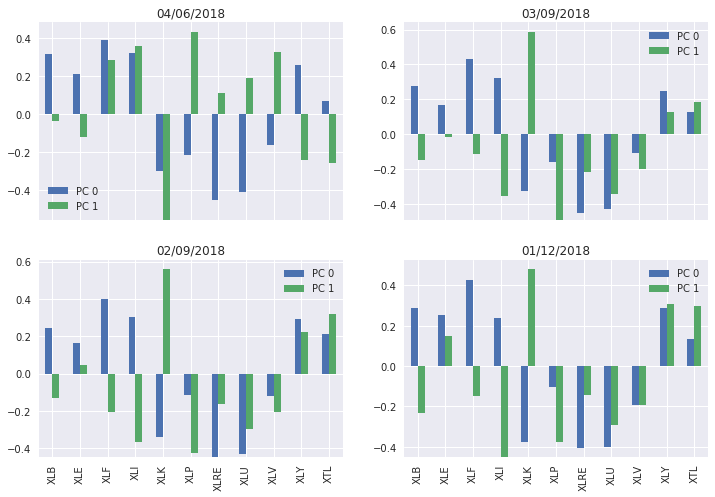

In [87]:
%matplotlib inline

import matplotlib.pyplot as plt

# plotStack is the subset of PCA's that will be plotted
plotStack = pl_stack[0:4]
numRows = int(len(plotStack)/2)

# Create a figure (collection of axes, one per plot, arranged in rows and columns)
fig, axes = plt.subplots(nrows=numRows, ncols=2, sharex=True)

# Set height, width (in inches) of figure
fig.set_figheight(numRows * 4)
fig.set_figwidth(12)

plotNum = 0

# Plot the PCA's
for stk in plotStack :
    suffix = stk[0].strftime("%Y%m%d")
    pca_df = stk[1]
    
    print("Stack {} shape: {}".format(stk[0], stk[1].shape))
    
    # Plot the first 2 PC's
    s_df = pca_df.loc[:, idx[ ["PC 0", "PC 1"],:]].stack()
    s_df.index = s_df.index.droplevel(0)
    # s_df
    
    ax0, ax1 = int(plotNum/2), (plotNum % 2)
    # print("({}, {})".format(ax0, ax1))
    s_df.plot.bar(ax=axes[ ax0, ax1 ])
    axes[ax0,ax1].set_title(stk[0].strftime("%m/%d/%Y"))
    plotNum += 1
    #gd.save_data(data, "sector_residuals_{}.pkl".format(suffix))
    

## Examine one PCA

datetime.datetime(2017, 3, 10, 0, 0)

PC 0      PC 1
Dt                                 
2017-03-10 XLB   0.316093  0.347756
           XLE   0.232558  0.115245
           XLF   0.153729  0.228565
           XLI   0.353332  0.314844
           XLK  -0.356683 -0.048411
           XLP  -0.475815  0.004644
           XLRE -0.343308  0.310481
           XLU  -0.430379  0.086154
           XLV   0.136356 -0.602673
           XLY  -0.124428  0.350665
           XTL  -0.082105  0.349354

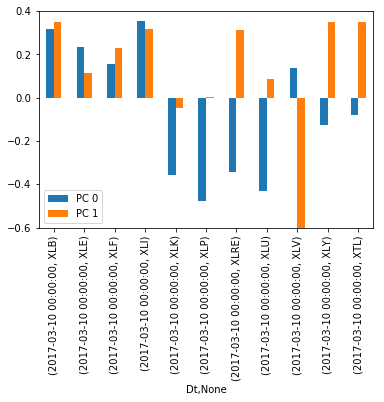

In [38]:
label, pca_df = pl_stack[14]
label
s_df = pca_df.loc[:, idx[ ["PC 0", "PC 1"],:]].stack()
s_df
s_df.plot.bar()

In [39]:
u_df = pca_df.loc[ :, idx[ ["PC 0", "PC 1"], :]].unstack(level=1)
u_df.index
u_df = u_df.reset_index()
u_df["ticker"] = u_df["level_1"].astype("category")
u_df["PC num"] = u_df["level_0"].astype("category")
u_df


MultiIndex(levels=[['Explained Var', 'Explained Var Ratio', 'PC 0', 'PC 1'], [0, 1, 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY', 'XTL'], [2017-03-10 00:00:00]],
           labels=[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
           names=[None, None, 'Dt'])

,level_0,level_1,Dt,0,ticker,PC num
0,PC 0,XLB,2017-03-10,0.316093,XLB,PC 0
1,PC 0,XLE,2017-03-10,0.232558,XLE,PC 0
2,PC 0,XLF,2017-03-10,0.153729,XLF,PC 0
3,PC 0,XLI,2017-03-10,0.353332,XLI,PC 0
4,PC 0,XLK,2017-03-10,-0.356683,XLK,PC 0
5,PC 0,XLP,2017-03-10,-0.475815,XLP,PC 0
6,PC 0,XLRE,2017-03-10,-0.343308,XLRE,PC 0
7,PC 0,XLU,2017-03-10,-0.430379,XLU,PC 0
8,PC 0,XLV,2017-03-10,0.136356,XLV,PC 0
9,PC 0,XLY,2017-03-10,-0.124428,XLY,PC 0


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


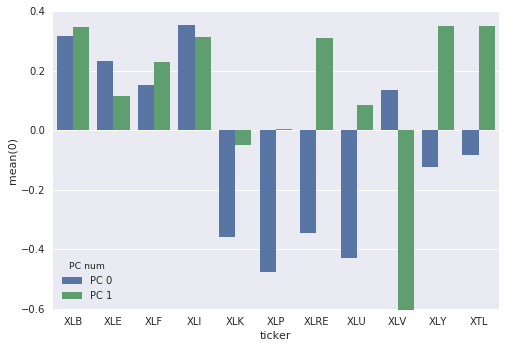

In [40]:

import seaborn as sns

sns.barplot(x="ticker", hue="PC num", y=0,  data=u_df)